## Introduction

Sources :
- BERT with TF Hub : https://wandb.ai/wandb_fc/french/reports/Comment-ajuster-BERT-pour-la-classification-de-textes---VmlldzoxNTEzNzQ3#r%C3%A9cup%C3%A9rons-le-jeu-de-donn%C3%A9es
- MultinomialNB with SkLearn : https://dylancastillo.co/text-classification-using-python-and-scikit-learn/
- EDA for NLP : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

L'objectif ici est de créer un classifieur d'article en fonction de son sujet principal

Le sujet principal choisi ici est le 'Football' car c'est un sujet pour lequel il est facile de trouver du contenu, et les autres articles proviennent d'un dataset de d'articles à propos du covid.  
Le tout en Français

Voici à quoi ressemble notre dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df = pd.read_csv('datasets/full_df_en.csv')

In [3]:
df.head()

,article_text,labels
0,Pele has been undergoing chemotherapy for bow...,football
1,Lionel Messi has his first goal in the knocko...,football
2,The Netherlands are back at the World Cup aft...,football
3,Lionel Messi is in perhaps his final World Cu...,football
4,Australia had a chance to equalise against Ar...,football


In [4]:
df.tail()

,article_text,labels
580,Seven private coal-based and hydropower projec...,other
581,Oil prices rebounded in Asia Monday but analys...,other
582,"Oil prices fell in Asia Tuesday, reversing sha...",other
583,The price of Liquefied Petroleum Gas (LPG) has...,other
584,A plunge in a gauge of Chinese factory activit...,other


Chaque article comporte 2 colonnes : 
- **article_text** : le corps de l'article
- **labels** : son label permettant d'identifier le sujet abordé

Voici des exemples des textes trouvables à l'interieur de notre dataset : 

Football :

In [5]:
df.article_text[2]

" The Netherlands are back at the World Cup after missing the 2018 edition and head coach Louis van Gaal will be confident they can spring a surprise and go far. They have made it to three World Cup finals in the past, but have yet to lift the coveted trophy as they have fallen at the final hurdle each time. Could this be the time they finally leave that pain behind and go all the way? They navigated their way past hosts Qatar, Ecuador and Senegal in the group stages, finishing top of Group A with seven points from three games. Van Gaal's side then beat the USMNT 3-1 in the last 16 to book their place in the quarter-finals. Here are the 26 players Van Gaal has picked for the tournament proper and how they could line up in the next round against Argentina."

Autres :

In [6]:
df.article_text[500]

'Asian shares were mixed Tuesday morning with Tokyo buoyed by a weak yen but falling commodity prices raised fears about global growth as Chinese stocks slipped after a brief reprieve in their month-long rout.Tokyo�s benchmark Nikkei 225 index rose 0.43 percent, Hong Kong was up 0.23 percent, Seoul was flat, Sydney gained 0.14 percent, while Singapore edged down 0.06 percent.Chinese shares fell sharply at the open as investors grew cautious after the market approached the key 4,000-point level, dealers said.The benchmark Shanghai Composite Index dropped 1.64 percent while the Shenzhen Composite Index, which tracks stocks on China�s second exchange, lost 1.91 percent.Both indices moved back into positive territory in later trading. The fresh volatility comes after Beijing launched a series of initiatives to staunch a bloodletting that saw a 30 percent plunge in Shanghai and trillions wiped off valuations.Among the measures were a police crackdown on short-selling and a ban on big shareh

## Exploratory Data Analysis

Nombre de mots par article

<AxesSubplot: >

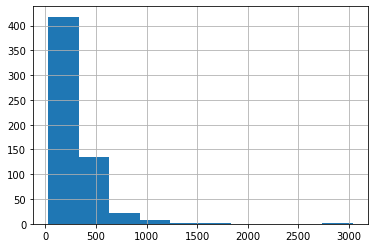

In [7]:
df.article_text.str.split().map(lambda x: len(x)).hist()

Taille moyenne des mots

<AxesSubplot: >

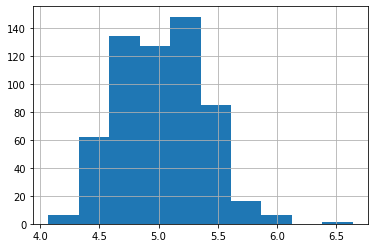

In [8]:
df.article_text.str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

###### Stopwords

In [9]:
en_stopwords = pd.read_csv('datasets/stopwords/stopword_en.csv')
list_en_stopwords = en_stopwords['0'].tolist()

In [10]:
def create_corpus(df, art_labels):
    """
      create a list of all the word in the dataframe 

      Parameters:
      df: Source dataframe
      art_labels: Name of the desired labels 

      Returns:
      corpus: List of str
    """
    temp_df = df[df.labels == art_labels]
    article_list_temp = temp_df['article_text'].str.split()
    article_list = article_list_temp.values.tolist()
    corpus = [word for i in article_list for word in i]
    return corpus

In [11]:
corpus_foot = create_corpus(df, 'football')
corpus_other = create_corpus(df, 'other')

In [12]:
from collections import Counter
def most_used_word_plt(corpus, title):
    """
      create a bar plot of the most used word in a corpus 

      Parameters:
      corpus: Source corpus
      title: Name of the label that will be displayed in the title 

      Returns:
      A bar plot
    """
    counter=Counter(corpus)
    most=counter.most_common()
    x, y= [], []
    for word,count in most[:75]:
        if (word.lower() not in list_en_stopwords):
            x.append(word)
            y.append(count)
            
    sns.barplot(x=y,y=x).set(title=f'Mots les plus utilisés parmis le label : {title}')

Liste des mots les plus utilisés parmis le label 'Football'

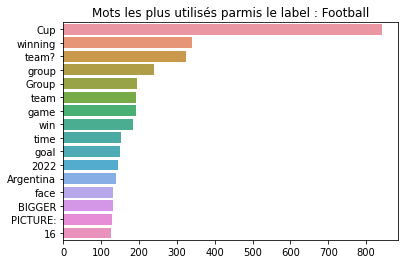

In [13]:
most_used_word_plt(corpus_foot, 'Football')

Liste des mots les plus utilisés parmis le label 'Autre'

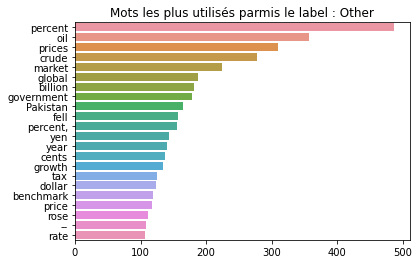

In [14]:
most_used_word_plt(corpus_other, 'Other')

###### WordCloud

Creation d'un WordCloud

In [15]:
from wordcloud import WordCloud

In [16]:
def create_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=list_en_stopwords,
        max_words=50,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(' '.join(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    plt.title(f'WordCloud des articles labélisés : {title} ', fontsize=40)
    plt.imshow(wordcloud)
    plt.show()

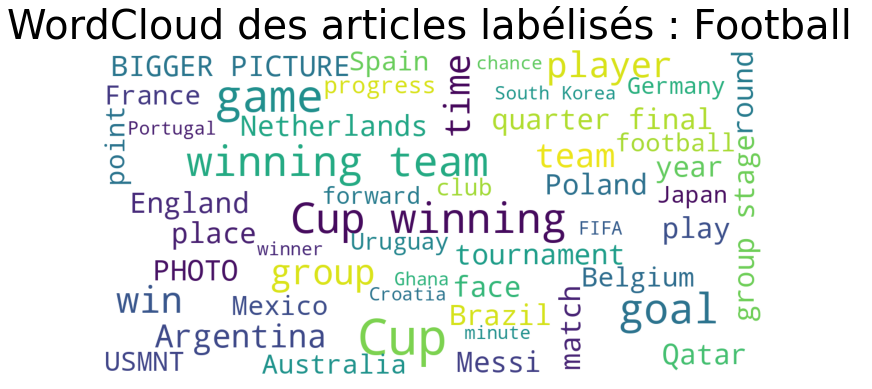

In [17]:
create_wordcloud(corpus_foot, 'Football')

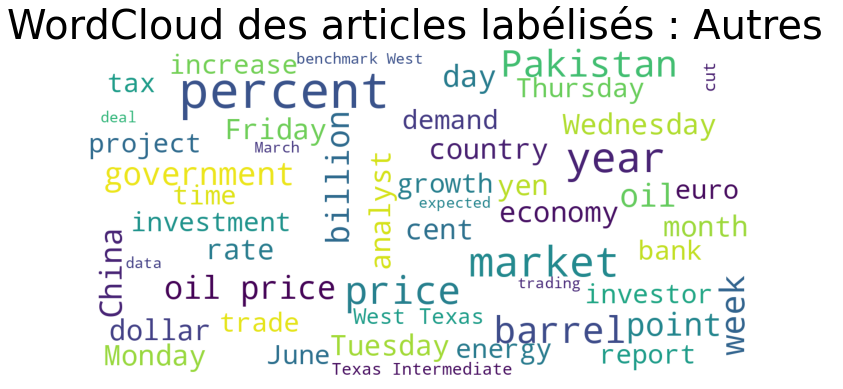

In [18]:
create_wordcloud(corpus_other, 'Autres')

## Pre-processing

Les

Transformation de la colonne labels en colonne binaire avec : 1 si 'football' et 0 si 'other'

In [19]:
df['labels'] = df['labels'].apply(lambda x: 1 if x=='football' else 0)

Séparation des données en Train & Test Sets

In [20]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.20, stratify=df.labels)

Les données de notre dataframe sont des données textuelles, elles ne sont donc pas utilisable dans notre model sous cette forme. 

Il faut donc les transformer en données numériques.  
Une des stratégies les plus populaires pour ce faire est l'approche du "Bag of Words".  
Cela va créer un tableau dans lequel chaque ligne représente un article, et chaque colonne représente les mots trouvés dans l'ensemble des articles, attribuant un 1 si le mot est present dans l'article et un 0 sinon.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(
    ngram_range=(1, 3), 
    stop_words=list_en_stopwords
)

X_train = vec.fit_transform(df_train.article_text)
X_test = vec.transform(df_test.article_text)

y_train = df_train.labels
y_test = df_test.labels

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['articl', 'mon'] not in stop_words.
  warnings.warn(


## Modeling

#### ML

Afin d'obtenir un 1er résultat, nous utiliserons l'algorithme Multinomial Naive Bayes, un algorithme majoritairement utilisé pour les problèmes de NLP.

###### Entrainement du model

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

###### Évaluation du model

In [23]:
from sklearn.metrics import classification_report

preds = nb.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        57

    accuracy                           1.00       117
   macro avg       1.00      1.00      1.00       117
weighted avg       1.00      1.00      1.00       117



Le résultat obtenu est de 100% de réussite, un résultat qui malgré qu'il soit rare, peut être expliqué par la difference assez marqué entre nos differents classes d'articles, mais aussi la longueur, donc le detail de ces derniers.

###### Test / Mise en situation

Testons avec quelques phrases :

In [24]:
phrase_1_foot = "The game that happens this sunday ended on a large victory for the home team"
phrase_2_autre = "The actual economic situation is mostly due to inflation"
print(f"La 1ère phrase parle de : {'football' if nb.predict(vec.transform([phrase_1_foot])) == 1 else 'other'} et la 2nde phrase parle de : {'football' if nb.predict(vec.transform([phrase_2_autre])) == 1 else 'other'}")

La 1ère phrase parle de : football et la 2nde phrase parle de : other


#### Multiple Algorithm Test

L'objectif ici est de tester plusieurs algorithmes afin d'observer les performances de chacun et de choisir le plus performant

In [25]:
features = vec.fit_transform(df.article_text).toarray()
labels = df['labels'].factorize()[0]

Nous allons comparer :
- Random Forest Classifier
- Logistic Regression
- Multinomial Naïve Bayes
- Linear Support Vector Classification


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

###### Évaluation des performances des models

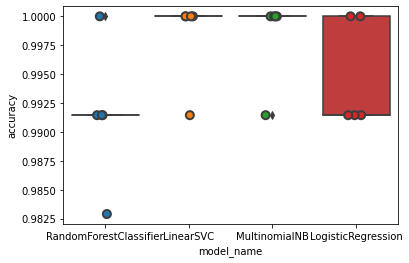

In [27]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

On peut en deduire que les algorithmes MultinomialNB & LinearSVC semblent donner de meilleurs résultats dans notre cas.

#### DL

Nous allons essayer d'utiliser le modèle pré entrainer BERT avec TF Hub.  

In [28]:
#!git clone --depth 1 -b v2.4.0 https://github.com/tensorflow/models.git

In [29]:
#!pip install -Uqr models/official/requirements.txt

In [30]:
#!pip install wandb

###### Import des librairies

In [31]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

import wandb
from wandb.keras import WandbCallback

###### Pre-Processing

Transformation de nos dataframes en TensorSlice :

In [32]:
train_data = tf.data.Dataset.from_tensor_slices((df_train['article_text'].values, df_train['labels'].values))
valid_data = tf.data.Dataset.from_tensor_slices((df_test['article_text'].values, df_test['labels'].values))

On defini au préalable les paramètres afin de pouvoir y faire des modifications plus facilement :

In [33]:
config = {'label_list' : [0, 1], # Label categories
          'max_seq_length' : 128, # maximum length of (token) input sequences
          'train_batch_size' : 32,
          'learning_rate': 2e-5,
          'epochs':5,
          'optimizer': 'adam',
          'dropout': 0.5,
          'train_samples': len(train_data),
          'valid_samples': len(valid_data),
          'train_split':0.1,
          'valid_split': 0.01
         }


###### Import de BERT

Chargement de BERT et son tokenizer :



In [34]:
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy() # checks if the bert layer we are using is uncased or not
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


###### Fonctions de transformation des données

In [35]:
# This provides a function to convert row to input features and label, 
# this uses the classifier_data_lib which is a class defined in the tensorflow model garden we installed earlier


def create_feature(text, label, label_list=config['label_list'], max_seq_length=config['max_seq_length'], tokenizer=tokenizer):
    """
    converts the datapoint into usable features for BERT using the classifier_data_lib


    Parameters:
    text: Input text string
    label: label associated with the text
    label_list: (list) all possible labels
    max_seq_length: (int) maximum sequence length set for bert
    tokenizer: the tokenizer object instantiated by the files in model assets


    Returns:
    feature.input_ids: The token ids for the input text string
    feature.input_masks: The padding mask generated 
    feature.segment_ids: essentially here a vector of 0s since classification
    feature.label_id: the corresponding label id from lable_list [0, 1] here
    """

    # since we only have 1 sentence for classification purpose, textr_b is None
    example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
    # since only 1 example, the index=0
    feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)


    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [36]:
def create_feature_map(text, label):
    """
    A tensorflow function wrapper to apply the transformation on the dataset.
    Parameters:
    Text: the input text string.
    label: the classification ground truth label associated with the input string


    Returns:
    A tuple of a dictionary and a corresponding label_id with it. The dictionary 
    contains the input_word_ids, input_mask, input_type_ids  
    """

    input_ids, input_mask, segment_ids, label_id = tf.py_function(create_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
    max_seq_length = config['max_seq_length']


    # py_func doesn't set the shape of the returned tensors.
    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
    return (x, label_id)


Appliquons maintenant nos traitement à nos datasets : 

In [37]:
train_data = (train_data.map(create_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)


                        .shuffle(1000)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE))

valid_data = (valid_data.map(create_feature_map, 
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                        .batch(32, drop_remainder=True)
                        .prefetch(tf.data.experimental.AUTOTUNE)) 


###### Création du model

In [38]:
def create_model():    
    input_word_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                           dtype=tf.int32,name="input_word_ids")

    input_mask = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                       dtype=tf.int32, name="input_mask")

    input_type_ids = tf.keras.layers.Input(shape=(config['max_seq_length'],), 
                                           dtype=tf.int32, name="input_type_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

    drop = tf.keras.layers.Dropout(config['dropout'])(pooled_output)
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)

    # inputs coming from the function
    model = tf.keras.Model(
      inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids}, 
      outputs=output)

    return model


In [39]:
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=config['learning_rate']),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.PrecisionAtRecall(0.5),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])
#model.summary()


In [40]:
config['model_name'] = 'BERT_EN'
print('Training configuration: ', config)

# Initialize W&B run
run = wandb.init(project='Finetune-BERT-Text-Classification', 
                 config=config,
                 group='BERT_EN', 
                 job_type='train')


Training configuration:  {'label_list': [0, 1], 'max_seq_length': 128, 'train_batch_size': 32, 'learning_rate': 2e-05, 'epochs': 5, 'optimizer': 'adam', 'dropout': 0.5, 'train_samples': 468, 'valid_samples': 117, 'train_split': 0.1, 'valid_split': 0.01, 'model_name': 'BERT_EN'}


wandb: Currently logged in as: robinfournier0998 (robi-data). Use `wandb login --relogin` to force relogin


###### Entrainement du model

In [41]:
with tf.device('/device:GPU:0'):
  epochs = config['epochs']
  history = model.fit(train_data,
                      validation_data=valid_data,
                      epochs=epochs,
                      verbose=1,
                      callbacks = [WandbCallback()])


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/5
14/14 [==============================] - ETA: 0s - loss: 0.3517 - binary_accuracy: 0.8549 - precision_at_recall: 0.9821 - precision: 0.8444 - recall: 0.8636

wandb: Adding directory to artifact (/content/wandb/run-20221204_011043-3hvqzdvb/files/model-best)... Done. 7.6s


14/14 [==============================] - 64s 3s/step - loss: 0.3517 - binary_accuracy: 0.8549 - precision_at_recall: 0.9821 - precision: 0.8444 - recall: 0.8636 - val_loss: 0.0630 - val_binary_accuracy: 1.0000 - val_precision_at_recall: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/5
14/14 [==============================] - ETA: 0s - loss: 0.0448 - binary_accuracy: 0.9978 - precision_at_recall: 1.0000 - precision: 0.9954 - recall: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20221204_011043-3hvqzdvb/files/model-best)... Done. 7.6s


14/14 [==============================] - 47s 3s/step - loss: 0.0448 - binary_accuracy: 0.9978 - precision_at_recall: 1.0000 - precision: 0.9954 - recall: 1.0000 - val_loss: 0.0098 - val_binary_accuracy: 1.0000 - val_precision_at_recall: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/5
14/14 [==============================] - ETA: 0s - loss: 0.0124 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20221204_011043-3hvqzdvb/files/model-best)... Done. 7.6s


14/14 [==============================] - 45s 3s/step - loss: 0.0124 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0032 - val_binary_accuracy: 1.0000 - val_precision_at_recall: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/5
14/14 [==============================] - ETA: 0s - loss: 0.0037 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20221204_011043-3hvqzdvb/files/model-best)... Done. 7.7s


14/14 [==============================] - 46s 3s/step - loss: 0.0037 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0020 - val_binary_accuracy: 1.0000 - val_precision_at_recall: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
14/14 [==============================] - ETA: 0s - loss: 0.0029 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000

wandb: Adding directory to artifact (/content/wandb/run-20221204_011043-3hvqzdvb/files/model-best)... Done. 7.7s


14/14 [==============================] - 46s 3s/step - loss: 0.0029 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_precision_at_recall: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000


###### Evaluation sur le dataset de test & visualisation

In [42]:
evaluation_results = model.evaluate(valid_data,return_dict=True)
evaluation_results

3/3 [==============================] - 1s 286ms/step - loss: 0.0012 - binary_accuracy: 1.0000 - precision_at_recall: 1.0000 - precision: 1.0000 - recall: 1.0000


{'loss': 0.0012394844088703394,
 'binary_accuracy': 1.0,
 'precision_at_recall': 1.0,
 'precision': 1.0,
 'recall': 1.0}

Visualisation des résultats de notre model

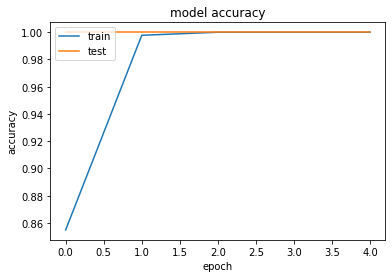

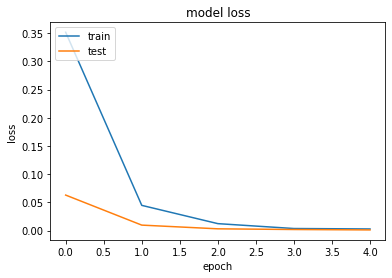

In [43]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusion

Au cours de ce projet, j'ai été amené à utiliser et ainsi comparer les performances d'un modèle simple de **ML** avec **SKLearn**, et un modèle pré-entrainé de **TF Hub** : **BERT**. 

La tâche à effectuer étant assez 'simple', les résultats sont très bons voir parfait dans les 2 cas.  
Il est donc assez difficile d'elire un "gagnant" en terme de performances. 

Cependant, la rapidité d'execution et la simplicité d'utilisation du modèle de ML le met, dans ce cas précis, loin devant BERT.